tratando con el dataframe...


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import FunctionTransformer


data = pd.read_json(path_or_buf='/content/inmuebles.json', orient='column')
data2 = pd.json_normalize(data.ident)
data3 = pd.json_normalize(data.listing, sep='_')
finaldata = pd.concat([data2, data3], axis=1)

filtro = (finaldata['types_usage'] == 'Residencial') & (finaldata['address_city'] == 'Rio de Janeiro')
finaldata2 = finaldata[filtro]
finaldata2.reset_index(drop=True, inplace=True)

finaldata2 = finaldata2.astype({
  'prices_price': 'float64',
  'prices_tax_iptu': 'float64',
  'prices_tax_condo': 'float64',
  'features_usableAreas': 'int64',
  'features_totalAreas': 'int64',
})

finaldata2['address_zone'] = finaldata2['address_zone'].replace('', np.nan)

dici = finaldata2[-finaldata2['address_zone'].isna()].drop_duplicates(subset=['address_neighborhood']).to_dict('records')
dic_zonas = {dic['address_neighborhood']: dic['address_zone'] for dic in dici}

for barrio, zona in dic_zonas.items():
    finaldata2.loc[finaldata2['address_neighborhood'] == barrio, 'address_zone'] = zona

finaldata2['prices_tax_iptu'].fillna(0, inplace=True)
finaldata2['prices_tax_condo'].fillna(0, inplace=True)

finaldata2.drop(['customerID', 'source', 'types_usage', 'address_city', 'address_location_lon', 'address_location_lat', 'address_neighborhood'], axis=1, inplace=True)

diccionario_columnas = {
    'types_unit': 'unit',
    'address_zone': 'zone',
    'prices_price': 'price',
    'prices_tax_condo': 'tax_condo',
    'prices_tax_iptu': 'tax_iptu',
    'features_bedrooms': 'bedrooms',
    'features_bathrooms': 'bathrooms',
    'features_suites': 'suites',
    'features_parkingSpaces': 'parkingSpaces',
    'features_usableAreas': 'usableAreas',
    'features_totalAreas': 'totalAreas',
    'features_floors': 'floors',
    'features_unitsOnTheFloor': 'unitsOnTheFloor',
    'features_unitFloor': 'unitFloor'
}

finaldata2 = finaldata2.rename(diccionario_columnas, axis=1)

non_numeric_columns = finaldata2.select_dtypes(exclude=[np.number]).columns
print(f"Non-numeric columns: {non_numeric_columns}")

finaldata2_numeric = finaldata2.drop(columns=non_numeric_columns)

#correlacion = finaldata2_numeric.corr()
#print(correlacion)

#cores = sns.color_palette('light:salmon',as_cmap=True)
#mask=np.zeros_like(correlacion)
#mask[np.tril_indices_from(mask)]=True
#with sns.axes_style("white"):
  #f,ax=plt.subplots(figsize=(13,8))
  #ax=sns.heatmap(correlacion,cmap=cores ,mask=mask,square=True,fmt='.2f',annot=True)
  #ax =sns.histplot(data=finaldata2,x="price",kde=True)
  #ax.figure.set_size_inches(20,10)
  #ax.set_title("histograma de precios")
  #ax.set_xlabel("Precio")

transformer = FunctionTransformer(np.log1p, validate=True)
finaldatatrans = transformer.transform(finaldata2.select_dtypes(exclude=['object']))
columnstrans=finaldata2.select_dtypes(exclude=['object']).columns
df_transfor=pd.concat([finaldata2.select_dtypes(include=['object']),pd.DataFrame(finaldatatrans,columns=columnstrans)],axis=1)
df_transfor_numeric = df_transfor.drop(columns=non_numeric_columns)

#print(df_transfor)

correlaciontrans = df_transfor_numeric.corr()
cores = sns.color_palette('light:salmon',as_cmap=True)
mask=np.zeros_like(correlaciontrans)
mask[np.tril_indices_from(mask)]=True
#with sns.axes_style("white"):
  #f,ax=plt.subplots(figsize=(13,8))
  #ax=sns.heatmap(correlaciontrans,cmap=cores ,mask=mask,square=True,fmt='.2f',annot=True)
  #ax =sns.histplot(data=df_transfor,x="price",kde=True)
  #ax.figure.set_size_inches(20,10)
  #ax.set_title("histograma de precios")
  #ax.set_xlabel("Precio")

variables_categoricas= df_transfor.select_dtypes(include=['object']).columns
print(variables_categoricas)
df_dummies=pd.get_dummies(df_transfor[variables_categoricas]).astype(int)
datos_finales=pd.concat([df_transfor.drop(columns=variables_categoricas,axis=1),df_dummies],axis=1)
datos_finales.head()


Non-numeric columns: Index(['unit', 'zone'], dtype='object')
Index(['unit', 'zone'], dtype='object')


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning: X has feature names, but FunctionTransformer was fitted without feature names
  warnings.warn(


,price,tax_iptu,tax_condo,bedrooms,bathrooms,suites,parkingSpaces,usableAreas,totalAreas,floors,unitsOnTheFloor,unitFloor,unit_Apartamento,unit_Casa,unit_Outros,zone_Zona Central,zone_Zona Norte,zone_Zona Oeste,zone_Zona Sul
0,10.714440,0.000000,5.017280,0.000000,0.000000,0.000000,0.693147,4.143135,4.143135,0.000000,0.000000,0.000000,0,0,1,0,0,1,0
1,10.714440,0.000000,4.795791,1.098612,0.693147,0.000000,0.693147,3.806662,0.000000,0.000000,0.000000,0.000000,1,0,0,0,0,1,0
2,10.819798,0.000000,4.615121,0.000000,0.000000,0.000000,0.000000,4.890349,4.890349,0.000000,0.000000,0.000000,0,0,1,0,0,1,0
3,10.819798,4.795791,5.993961,1.386294,1.098612,0.693147,0.693147,4.110874,0.000000,1.386294,1.609438,1.098612,1,0,0,0,0,1,0
4,10.819798,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.303305,5.303305,0.000000,0.000000,0.000000,0,0,1,0,0,1,0


separando datos


In [3]:
x = datos_finales.drop('price', axis=1)
y = datos_finales['price']

division en conjunto de entrenamiento y prueba


In [4]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [5]:
from sklearn.linear_model import LinearRegression
lr=LinearRegression()
lr.fit(x_train,y_train)
prediccion_lr=lr.predict(x_test)

resultado de la prediccion

In [6]:
prediccion_lr

array([13.25768024, 12.45705313, 12.91487963, ..., 13.13161073,
       12.42379775, 14.49548233])

In [7]:
np.expm1(13.25768024)

572448.7513552749

coeficiente de determinacion


In [8]:
from sklearn.metrics import r2_score
r2_lr=r2_score(y_test,prediccion_lr)
r2_lr

0.7880682093407632

DECISION TREE
Segunda opcion de modelo


In [9]:
from sklearn.tree import DecisionTreeRegressor
dtr=DecisionTreeRegressor(random_state=42,max_depth=5)
dtr.fit(x_train,y_train)
prediccion_dtr=dtr.predict(x_test)
prediccion_dtr

array([13.55136531, 12.33741035, 13.24458243, ..., 13.23643158,
       12.33741035, 14.55274625])

Grafico de error de prediccion YellowBrick, este grafico muestra una linea recta vertical, cuanto mas se acerque a los 45 grados mas preciso habara resultado el modelo.


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


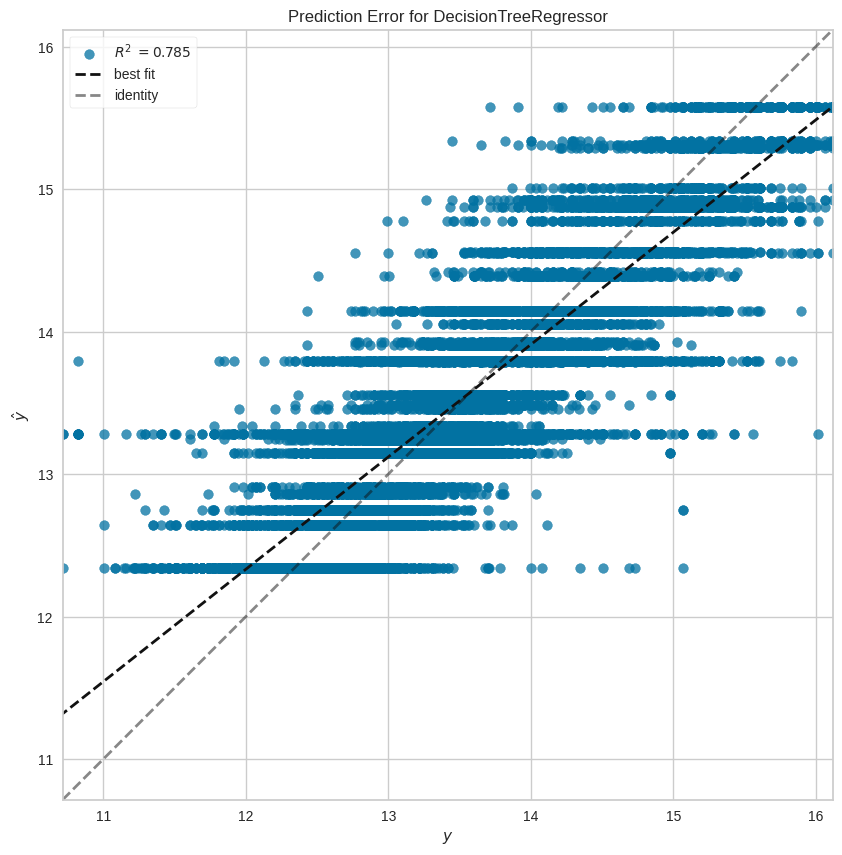

<Axes: title={'center': 'Prediction Error for DecisionTreeRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [10]:
from yellowbrick.regressor import PredictionError
fig,ax=plt.subplots(figsize=(10,10))
pev=PredictionError(dtr)
pev.fit(x_train,y_train)
pev.score(x_test,y_test)
pev.poof()

coeficiente de determinacion

In [11]:
r2_dtr=r2_score(y_test,prediccion_dtr)
r2_dtr

0.7846916218477392

RANDOM FOREST , tercer modelo de regresion lineal.
Parametros diferenciadores del modelo anterior DecisionTree y RandomForest:


*   n_estimators:numero de arboles contenidos en el bosque.
*   bootstrap:define si se utilizara el metodo de muestreo estadistico bootstrap.
*   oob_score:define si se utilizara el metodo de muestreo out of bag para medir los errores de prediccion.
*   n_jobs: numero de jobs que se ejecutan en paralelo.
*   warm_start:adecuacion de un nuevo bosque o usa un bosque existente.
*   max_samples:en caso de qu bootstrap sea true,define el numero de muestras que se extraeran de X para entrenar cada arbol base.

In [12]:
from sklearn.ensemble import RandomForestRegressor
rf=RandomForestRegressor(n_estimators=10,max_depth=5,random_state=42)
rf.fit(x_train,y_train)
prediccion_rf=rf.predict(x_test)


Grafico de error de prediccion

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


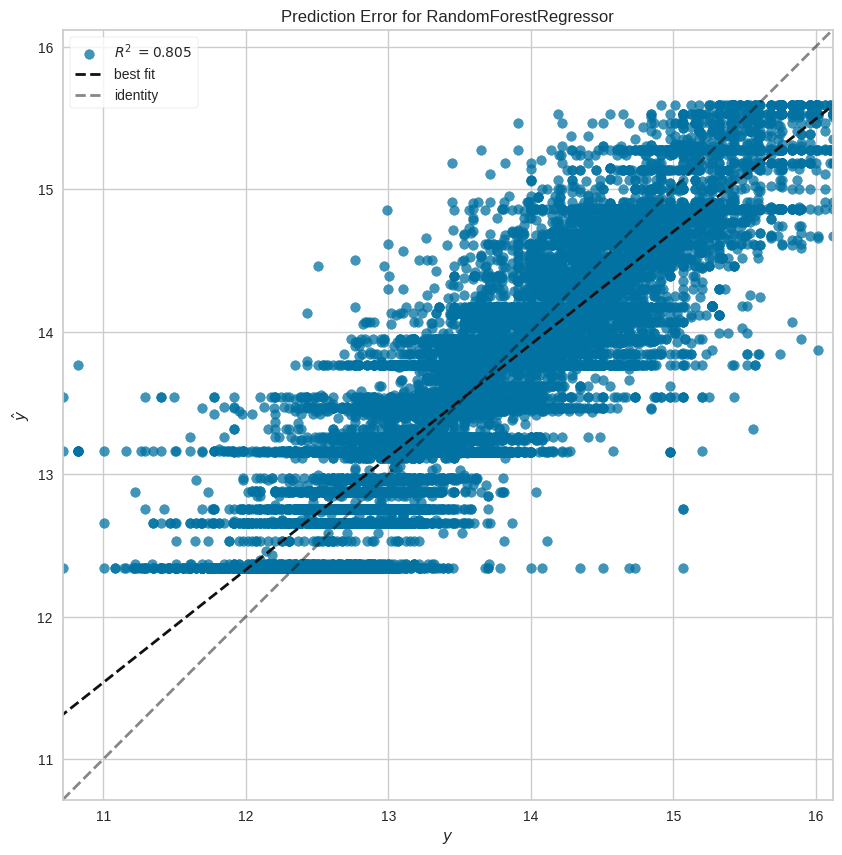

<Axes: title={'center': 'Prediction Error for RandomForestRegressor'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [13]:
from yellowbrick.regressor import PredictionError
fig,ax=plt.subplots(figsize=(10,10))
pev=PredictionError(rf)
pev.fit(x_train,y_train)
pev.score(x_test,y_test)
pev.poof()

Metrica de desempeno del modelo RandomForest:

In [14]:
r2fr=r2_score(y_test,prediccion_rf)
r2fr

0.805273364453047

#Tecnicas de optimizacion de modelos ML

1.-Cross Validation (validacion cruzada)
*   Es una tecnica ampliamente utilizada para evaluar el rendimiento de los modelos y la consiguiente verificacion de tendencias en el aprendizaje automatico. Consiste en  perticionar los datos en  subconjuntos(partes), donde un subconjunto se usa para entrenamiento y ptro subconjunto se usa para probar y evaluar el rendimiento del modelo.
*   Los datos particionados son los de entrenamiento (70% de os originales)
*   K-fold:el conjunto de entrenamiento se divide aleatoriamente en K subconjuntos de aproximadamente el mismo tamano, luego se realizan K iteracionesm done los subconjuntos K-1 son para entrenaniento y 1 para validacion.
*   El rendimiento calculado por validacion cruzada k-fold es el promedio de todos los valores calculados en cada iteracion.

2.- Randomized Paramater Optimization (Optimizacion Aleatoria de parametros)
*   Define un espacio de busqueda como un dominio acotado de valores de hiperparametros y puntos de muestra aleatorios en ese dominio.







# Optimizando el modelo DecisionTree

In [15]:
#division en 3 pedazos del dataset
from sklearn.model_selection import KFold

#definiendo el K numero de subconjuntos
cv=KFold(n_splits=5,shuffle=True)

Cross validation


In [16]:
from sklearn.model_selection import cross_val_score
accuracy_cross_val_r2=cross_val_score(estimator=dtr,
                                      X=x_train,
                                      y=y_train,
                                      cv=cv,
                                      scoring='r2')
print('accuracy promdeio de r2: {}'.format(round(accuracy_cross_val_r2.mean(),3)))

accuracy promdeio de r2: 0.782


Random Search Validation


In [17]:
#seleccion del hiperparametro
param_random_dt={
    'criterion':['squared_error','absolute_error'],
    'max_depth':[6,8,10,12,14,16],
    'min_samples_split':[8,10,12,14,16],
    'min_samples_leaf':[6,8,10],
    'max_features':['auto','sqrt','log2']
    }



In [18]:
from sklearn.model_selection import RandomizedSearchCV


In [19]:
random_cv_dt=RandomizedSearchCV(
    dtr,
    param_random_dt,
    n_iter=5,
    cv=cv,
    scoring='r2',
    n_jobs=-1
)


In [20]:
randomcv_dtr=random_cv_dt.fit(x_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
5 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_pa

In [21]:
pd.DataFrame(randomcv_dtr.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.014969,0.002818,0.000000,0.000000,12,6,auto,16,squared_error,"{'min_samples_split': 12, 'min_samples_leaf': ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
1,0.082488,0.008265,0.006077,0.000742,10,8,log2,10,squared_error,"{'min_samples_split': 10, 'min_samples_leaf': ...",0.828805,0.816829,0.827300,0.825447,0.818117,0.823300,0.004892,2
2,0.076825,0.010664,0.006681,0.002485,10,6,sqrt,8,squared_error,"{'min_samples_split': 10, 'min_samples_leaf': ...",0.798629,0.778116,0.799024,0.803701,0.776119,0.791118,0.011587,3
3,0.077228,0.005245,0.006516,0.000945,12,6,sqrt,8,squared_error,"{'min_samples_split': 12, 'min_samples_leaf': ...",0.798629,0.778116,0.799024,0.803701,0.776119,0.791118,0.011587,3
4,0.095826,0.012573,0.006661,0.001225,12,10,log2,12,squared_error,"{'min_samples_split': 12, 'min_samples_leaf': ...",0.840111,0.837349,0.836797,0.832765,0.836371,0.836679,0.002352,1


In [22]:
randomcv_dtr.best_params_


{'min_samples_split': 12,
 'min_samples_leaf': 10,
 'max_features': 'log2',
 'max_depth': 12,
 'criterion': 'squared_error'}

In [23]:
randomcv_dtr.best_score_


0.8366785981068492

TESTEANDO EL MODELO CON LOS HIPERPARAMETROS DE OPTIMIZACION


In [24]:
dtr_optimizado=DecisionTreeRegressor(
    criterion='squared_error',
    max_depth=12,
    max_features='log2',
    min_samples_leaf=8,
    min_samples_split=16)

In [25]:
dtr_optimizado.fit(x_train,y_train)

DecisionTreeRegressor(max_depth=12, max_features='log2', min_samples_leaf=8,
                      min_samples_split=16)

In [26]:
prediccion_dtr_optimizado=dtr_optimizado.predict(x_test)

In [27]:
r2_dtr_optimizado=r2_score(y_test,prediccion_dtr_optimizado)
r2_dtr_optimizado

0.8376521348799177

# Optimizando el modelo random forest

Cross Validation

In [28]:
accuracyRF_cross_val_r2=cross_val_score(estimator=rf,
                                      X=x_train,
                                      y=y_train,
                                      cv=cv,
                                      scoring='r2')
print('accuracy promdeio de r2: {}'.format(round(accuracyRF_cross_val_r2.mean(),3)))

accuracy promdeio de r2: 0.8


Random Search Validation

In [29]:
param_ramdom_rf={
    'n_estimators':[150,200],
    'max_depth':[20,30],
    'min_samples_split':[8,10],
    'min_samples_leaf':[3]
}

In [30]:
random_cv_rf=RandomizedSearchCV(
    rf,
    param_ramdom_rf,
    n_iter=5,
    cv=cv,
    scoring='r2',
    n_jobs=-1,
    random_state=42
)


In [31]:
rf_randomcv=random_cv_rf.fit(x_train,y_train)

In [32]:
pd.DataFrame(rf_randomcv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,68.972168,5.153438,1.103946,0.345524,200,8,3,20,"{'n_estimators': 200, 'min_samples_split': 8, ...",0.893468,0.892912,0.898233,0.895639,0.895113,0.895073,0.001874,2
1,68.932648,3.642366,1.001602,0.375592,200,8,3,30,"{'n_estimators': 200, 'min_samples_split': 8, ...",0.893509,0.893014,0.898157,0.895725,0.895100,0.895101,0.001823,1
2,51.886903,2.922418,0.801710,0.240871,150,8,3,20,"{'n_estimators': 150, 'min_samples_split': 8, ...",0.893238,0.892745,0.898112,0.895435,0.895141,0.894934,0.001900,3
3,68.311814,3.538185,0.923658,0.292604,200,10,3,30,"{'n_estimators': 200, 'min_samples_split': 10,...",0.893165,0.892647,0.897788,0.895177,0.894774,0.894710,0.001807,4
4,48.488796,6.074462,0.469111,0.053058,150,10,3,20,"{'n_estimators': 150, 'min_samples_split': 10,...",0.892969,0.892408,0.897682,0.894812,0.894744,0.894523,0.001844,5


In [33]:
random_cv_rf.best_params_

{'n_estimators': 200,
 'min_samples_split': 8,
 'min_samples_leaf': 3,
 'max_depth': 30}

In [34]:
random_cv_rf.best_score_

0.8951008102864872

Testeando el modelo RF con los hiperparametros de optimizacion

In [35]:
rf_optimizado=RandomForestRegressor(
    n_estimators=200,
    max_depth=30,
    min_samples_leaf=3,
    min_samples_split=8,
    random_state=42
)

In [36]:
rf_optimizado.fit(x_train,y_train)

RandomForestRegressor(max_depth=30, min_samples_leaf=3, min_samples_split=8,
                      n_estimators=200, random_state=42)

In [37]:
prediccion_rf_optimizado=rf_optimizado.predict(x_test)

In [38]:
r2_score(y_test,prediccion_rf_optimizado)

0.8950447657106755